In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
import pandas as pd

filepath = 'C:/AI_study/dataset/'
# Load all 9 files as a list
filenames = [
    'S01R01.txt', 'S01R02.txt', 'S02R01.txt', 'S02R02.txt', 'S03R01.txt', 'S03R02.txt',
    'S03R03.txt', 'S04R01.txt', 'S05R01.txt', 'S05R02.txt', 'S06R01.txt', 'S06R02.txt',
    'S07R02.txt', 'S08R01.txt', 'S09R01.txt', 'S10R01.txt'
]

# Create an empty list to store DataFrames
dfs = []

# Iterate over each filename, load the CSV file, and append the DataFrame to the list
for filename in filenames:
    df = pd.read_csv(filepath + filename, sep="\s+", header=None)
    user_number = int(filename[1:3])
    df['User_Number'] = user_number
    dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Set column names
columns = "TS, Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number".split(",")
df.columns = columns

print(df)

              TS   Ankel_1  Ankel_2  Ankel_3  Thigh_1  Thigh_2  Thigh_3  \
0             15        70       39     -970        0        0        0   
1             31        70       39     -970        0        0        0   
2             46        60       49     -960        0        0        0   
3             62        60       49     -960        0        0        0   
4             78        50       39     -960        0        0        0   
...          ...       ...      ...      ...      ...      ...      ...   
1798357  3020296      -131      107     -960        0        0        0   
1798358  3020312      -121      127     -970        0        0        0   
1798359  3020328      -141      117     -960        0        0        0   
1798360  3020343      -131      127     -980        0        0        0   
1798361  3020359      -141        0        0        0        0        0   

         Trunk_1  Trunk_2  Trunk_3  status  User_Number  
0              0        0        0       

In [3]:
df.head()

,TS,Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number
0,15,70,39,-970,0,0,0,0,0,0,0,1
1,31,70,39,-970,0,0,0,0,0,0,0,1
2,46,60,49,-960,0,0,0,0,0,0,0,1
3,62,60,49,-960,0,0,0,0,0,0,0,1
4,78,50,39,-960,0,0,0,0,0,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798362 entries, 0 to 1798361
Data columns (total 12 columns):
 #   Column       Dtype
---  ------       -----
 0   TS           int64
 1    Ankel_1     int64
 2   Ankel_2      int64
 3   Ankel_3      int64
 4   Thigh_1      int64
 5   Thigh_2      int64
 6   Thigh_3      int64
 7   Trunk_1      int64
 8   Trunk_2      int64
 9   Trunk_3      int64
 10  status       int64
 11  User_Number  int64
dtypes: int64(12)
memory usage: 164.6 MB


In [5]:
df.describe()

,TS,Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number
count,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06,1.798362e+06
mean,1.077208e+06,-5.840035e+01,8.205787e+02,5.888554e+01,-2.079832e+01,6.020473e+02,-3.875299e+01,4.821141e+01,7.631992e+02,-1.167351e+02,6.525399e-01,5.211849e+00
std,7.637586e+05,5.273884e+02,4.954709e+02,5.610358e+02,5.378507e+02,4.358368e+02,4.883318e+02,2.827634e+02,4.226899e+02,4.159825e+02,5.879011e-01,2.897030e+00
min,1.500000e+01,-3.123400e+04,-3.276300e+04,-3.148800e+04,-2.184600e+04,-2.967300e+04,-2.431800e+04,-4.621000e+03,-3.400000e+03,-4.786000e+03,0.000000e+00,1.000000e+00
25%,4.390620e+05,-2.220000e+02,7.450000e+02,6.900000e+01,-2.630000e+02,2.590000e+02,-1.010000e+02,-8.700000e+01,7.800000e+02,-2.030000e+02,0.000000e+00,3.000000e+00
50%,9.293750e+05,-3.000000e+01,9.700000e+02,2.170000e+02,-1.800000e+01,6.290000e+02,9.000000e+01,2.900000e+01,9.520000e+02,-3.800000e+01,1.000000e+00,5.000000e+00
75%,1.621328e+06,1.210000e+02,1.019000e+03,3.260000e+02,2.180000e+02,9.620000e+02,2.420000e+02,1.940000e+02,1.009000e+03,1.160000e+02,1.000000e+00,8.000000e+00
max,3.058390e+06,3.072500e+04,3.200200e+04,3.174400e+04,2.662500e+04,3.259800e+04,2.841800e+04,6.707000e+03,2.429800e+04,4.339000e+03,2.000000e+00,1.000000e+01


In [6]:
df.columns

Index(['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3', 'status', 'User_Number'],
      dtype='object')

In [7]:
df['status'].value_counts()

status
1    959685
0    731768
2    106909
Name: count, dtype: int64

In [8]:
df.shape

(1798362, 12)

In [9]:
# status 열에서 값이 0인 행 제거
df = df[df['status'] != 0]

# status 열에서 값이 1인 행을 0으로, 값이 2인 행을 1로 바꾸기
df['status'] = df['status'].replace({1: 0, 2: 1})

In [10]:
df['status'].value_counts()

status
0    959685
1    106909
Name: count, dtype: int64

In [11]:
df.shape

(1066594, 12)

I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


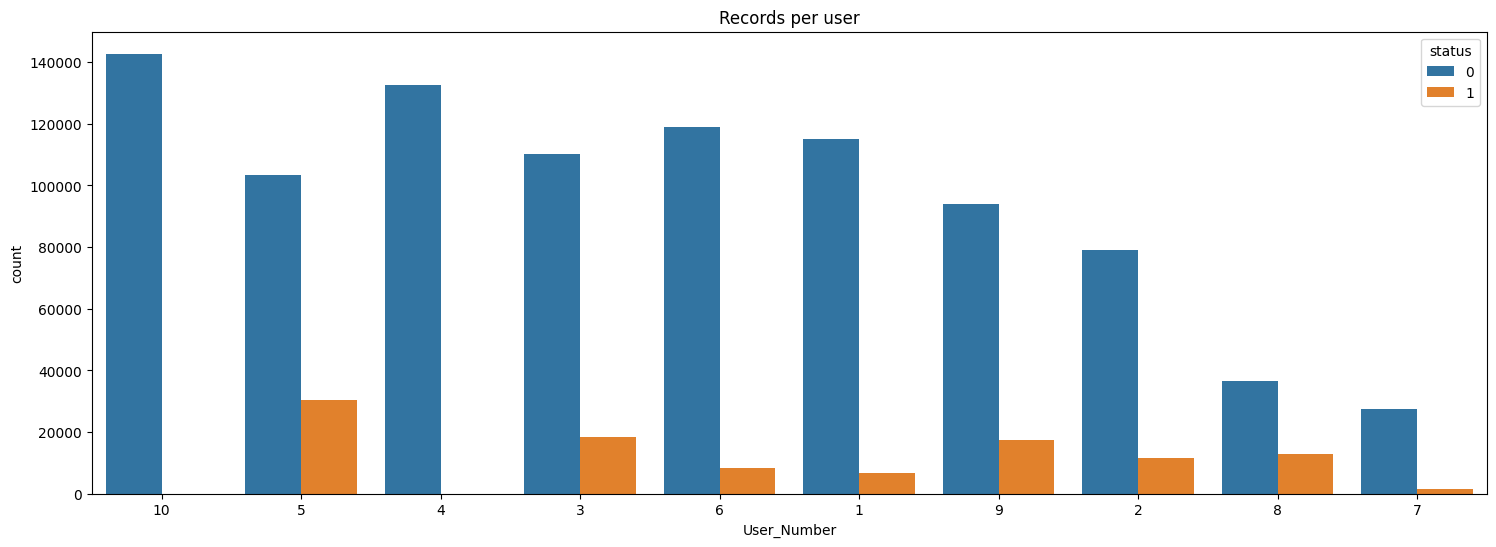

In [12]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "User_Number", hue="status", data = df,
              order = df.User_Number.value_counts().index)
plt.title("Records per user");

In [13]:
X = df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']].values
y = df['status'].values.reshape(-1, 1)

In [14]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(682620, 10) (682620, 1)
(213319, 10) (213319, 1)


In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)

In [16]:
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]

## Data Balancing 전 모델

In [17]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=(n_features,)))
model.add(keras.layers.Dense(128))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                        

In [18]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
5333/5333 [==============================] - 16s 3ms/step - loss: 0.3341 - accuracy: 0.8918 - val_loss: 0.3524 - val_accuracy: 0.8960
Epoch 2/10
5333/5333 [==============================] - 14s 3ms/step - loss: 0.2936 - accuracy: 0.8979 - val_loss: 0.3021 - val_accuracy: 0.8995
Epoch 3/10
5333/5333 [==============================] - 14s 3ms/step - loss: 0.2862 - accuracy: 0.8984 - val_loss: 0.2845 - val_accuracy: 0.8992
Epoch 4/10
5333/5333 [==============================] - 14s 3ms/step - loss: 0.2846 - accuracy: 0.8984 - val_loss: 0.2904 - val_accuracy: 0.8994
Epoch 5/10
5333/5333 [==============================] - 14s 3ms/step - loss: 0.2839 - accuracy: 0.8984 - val_loss: 0.3346 - val_accuracy: 0.8848
Epoch 6/10
5333/5333 [==============================] - 14s 3ms/step - loss: 0.2833 - accuracy: 0.8984 - val_loss: 0.3001 - val_accuracy: 0.8996
Epoch 7/10
5333/5333 [==============================] - 14s 3ms/step - loss: 0.2827 - accuracy: 0.8984 - val_loss: 0.2843 - val_ac

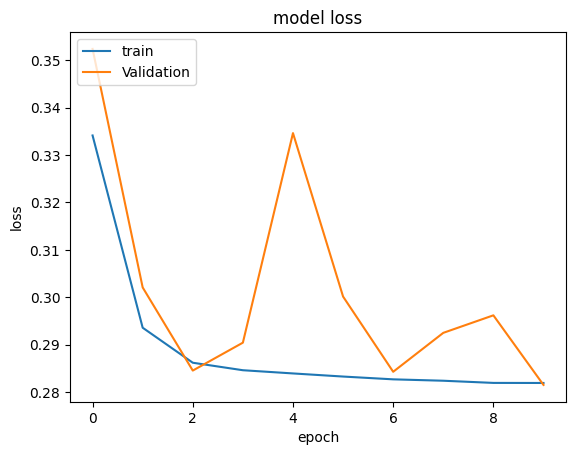

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

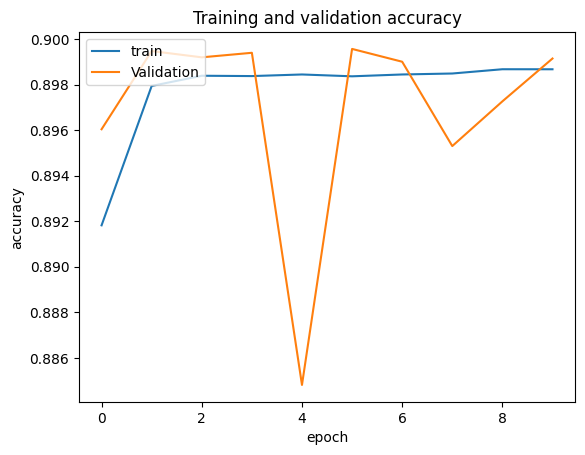

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

6667/6667 [==============================] - 5s 788us/step
f1_score =  0.8525436259228623
0.8991651001551667
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    191937
           1       0.24      0.00      0.01     21382

    accuracy                           0.90    213319
   macro avg       0.57      0.50      0.48    213319
weighted avg       0.83      0.90      0.85    213319



<Axes: >

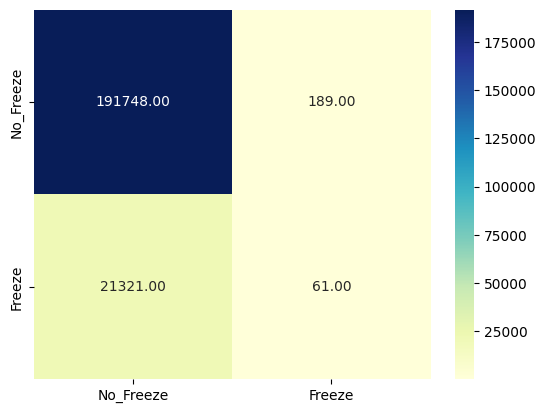

In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['No_Freeze','Freeze']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

## Smote()를 통해 각 User 별로 status의 개수 동일하게 밸런싱

In [22]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# 데이터프레임 그룹화
grouped = df.groupby('User_Number')

# 각 그룹에 대해 밸런싱 적용
balanced_dfs = []
for group_name, group_data in grouped:
    # 그룹 내 클래스 개수 확인
    num_classes = group_data['status'].nunique()
    
    # 클래스가 하나 이상인 경우에만 밸런싱 적용, Standing이 존재하지 않는 user가 있어서
    if num_classes > 1:
        # Smote를 통한 Oversampling
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(group_data.drop(['status', 'User_Number'], axis=1), group_data['status'])
        balanced_group_df = pd.concat([pd.DataFrame(X_resampled, columns=group_data.drop(['status', 'User_Number'], axis=1).columns),
                                       pd.DataFrame({'status': y_resampled})], axis=1)

        # 'user_id' 열 추가
        balanced_group_df['User_Number'] = group_name

        balanced_dfs.append(balanced_group_df)
    else:
        balanced_dfs.append(group_data)

# 재결합
balanced_df = pd.concat(balanced_dfs)

# 결과 확인
print(balanced_df.head())

       TS   Ankel_1  Ankel_2  Ankel_3  Thigh_1  Thigh_2  Thigh_3  Trunk_1  \
0  750000       -30      990      326      -45      972      181      -38   
1  750015       -30     1000      356      -18      981      212      -48   
2  750031       -20      990      336       18      981      222      -38   
3  750046       -20     1000      316       36      990      222      -19   
4  750062         0      990      316       36      990      212      -29   

   Trunk_2  Trunk_3  status  User_Number  
0     1000       29       0            1  
1     1028       29       0            1  
2     1038        9       0            1  
3     1038        9       0            1  
4     1038       29       0            1  


In [23]:
print(balanced_df['status'].value_counts())

status
0    959685
1    684481
Name: count, dtype: int64


In [24]:
balanced_df.head()

,TS,Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number
0,750000,-30,990,326,-45,972,181,-38,1000,29,0,1
1,750015,-30,1000,356,-18,981,212,-48,1028,29,0,1
2,750031,-20,990,336,18,981,222,-38,1038,9,0,1
3,750046,-20,1000,316,36,990,222,-19,1038,9,0,1
4,750062,0,990,316,36,990,212,-29,1038,29,0,1


In [25]:
df.shape

(1066594, 12)

I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


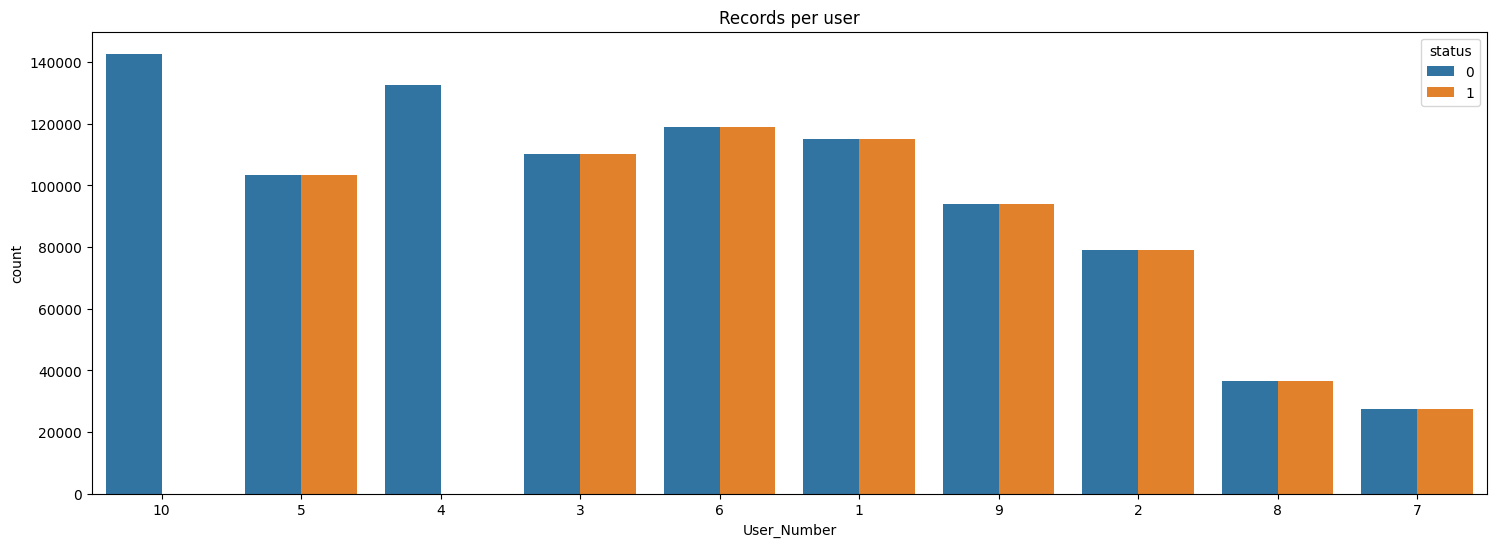

In [26]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "User_Number", hue="status", data = balanced_df,
              order = df.User_Number.value_counts().index)
plt.title("Records per user");

In [27]:
X = balanced_df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']].values
y = balanced_df['status'].values.reshape(-1, 1)

In [28]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1052265, 10) (1052265, 1)
(328834, 10) (328834, 1)


In [29]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)

In [30]:
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]

In [31]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=(n_features,)))
model.add(keras.layers.Dense(128))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                704       
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                      

In [32]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
8221/8221 [==============================] - 22s 3ms/step - loss: 0.6142 - accuracy: 0.6274 - val_loss: 0.5647 - val_accuracy: 0.6717
Epoch 2/10
8221/8221 [==============================] - 22s 3ms/step - loss: 0.5648 - accuracy: 0.6663 - val_loss: 0.5580 - val_accuracy: 0.6723
Epoch 3/10
8221/8221 [==============================] - 22s 3ms/step - loss: 0.5584 - accuracy: 0.6707 - val_loss: 0.5519 - val_accuracy: 0.6753
Epoch 4/10
8221/8221 [==============================] - 22s 3ms/step - loss: 0.5510 - accuracy: 0.6752 - val_loss: 0.5400 - val_accuracy: 0.6791
Epoch 5/10
8221/8221 [==============================] - 22s 3ms/step - loss: 0.5381 - accuracy: 0.6791 - val_loss: 0.5444 - val_accuracy: 0.6744
Epoch 6/10
8221/8221 [==============================] - 22s 3ms/step - loss: 0.5357 - accuracy: 0.6810 - val_loss: 0.5382 - val_accuracy: 0.6839
Epoch 7/10
8221/8221 [==============================] - 22s 3ms/step - loss: 0.5316 - accuracy: 0.6868 - val_loss: 0.5210 - val_ac

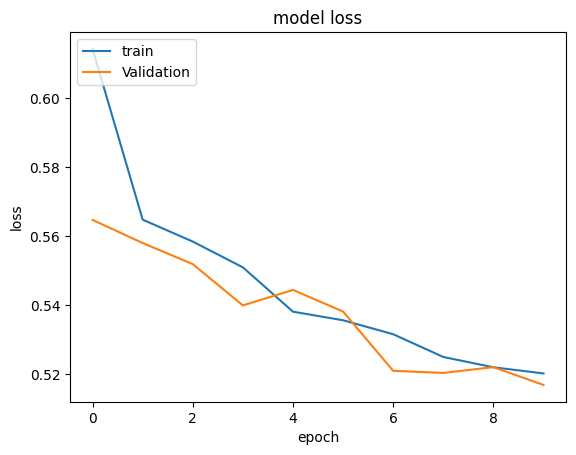

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

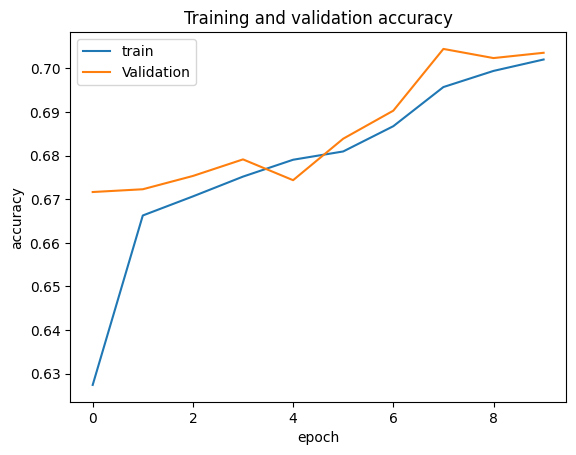

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

10277/10277 [==============================] - 8s 780us/step
f1_score =  0.7066226173391013
0.7049210239817051
              precision    recall  f1-score   support

           0       0.81      0.65      0.72    191937
           1       0.61      0.79      0.69    136897

    accuracy                           0.70    328834
   macro avg       0.71      0.72      0.70    328834
weighted avg       0.73      0.70      0.71    328834



<Axes: >

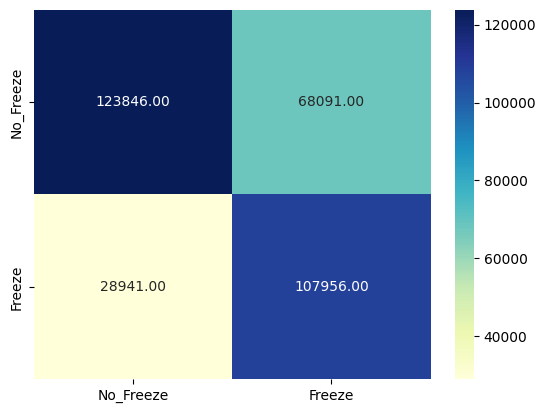

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['No_Freeze','Freeze']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

## Freeze 활동이 없는 user에 의해 전체 status의 밸런스가 맞지 않는 것을 해결하기 위해 Freeze 활동이 없는 user의 행 삭제

In [36]:
# 'Freeze' 활동을 하는 User_Number 추출
Freeze_users = balanced_df[balanced_df['status'] == 1]['User_Number'].unique()

# 'Freeze' 활동을 하지 않는 User_Number 추출
Freeze_absent_users = [User_Number for User_Number in df['User_Number'].unique() if User_Number not in Freeze_users]

# 'Freeze' 활동을 하지 않는 User_Number 해당하는 행 삭제
balanced_df = balanced_df[~balanced_df['User_Number'].isin(Freeze_absent_users)]

# 결과 확인
print(balanced_df)

             TS   Ankel_1  Ankel_2  Ankel_3  Thigh_1  Thigh_2  Thigh_3  \
0        750000       -30      990      326      -45      972      181   
1        750015       -30     1000      356      -18      981      212   
2        750031       -20      990      336       18      981      222   
3        750046       -20     1000      316       36      990      222   
4        750062         0      990      316       36      990      212   
...         ...       ...      ...      ...      ...      ...      ...   
188151   719786       296     1047       21     -213      913      206   
188152   457967       -14     1649      261     -802     1205      352   
188153   637802       233      923      -12       13      829      333   
188154  1010843       222     1008       98     -145      962      150   
188155   833621        -1      992      193     -316      894      228   

        Trunk_1  Trunk_2  Trunk_3  status  User_Number  
0           -38     1000       29       0            1

In [37]:
print(balanced_df['status'].value_counts())

status
0    684481
1    684481
Name: count, dtype: int64


In [38]:
balanced_df.head()

,TS,Ankel_1,Ankel_2,Ankel_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,User_Number
0,750000,-30,990,326,-45,972,181,-38,1000,29,0,1
1,750015,-30,1000,356,-18,981,212,-48,1028,29,0,1
2,750031,-20,990,336,18,981,222,-38,1038,9,0,1
3,750046,-20,1000,316,36,990,222,-19,1038,9,0,1
4,750062,0,990,316,36,990,212,-29,1038,29,0,1


In [39]:
balanced_df.shape

(1368962, 12)

I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
I:\anaconda3\envs\test01\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


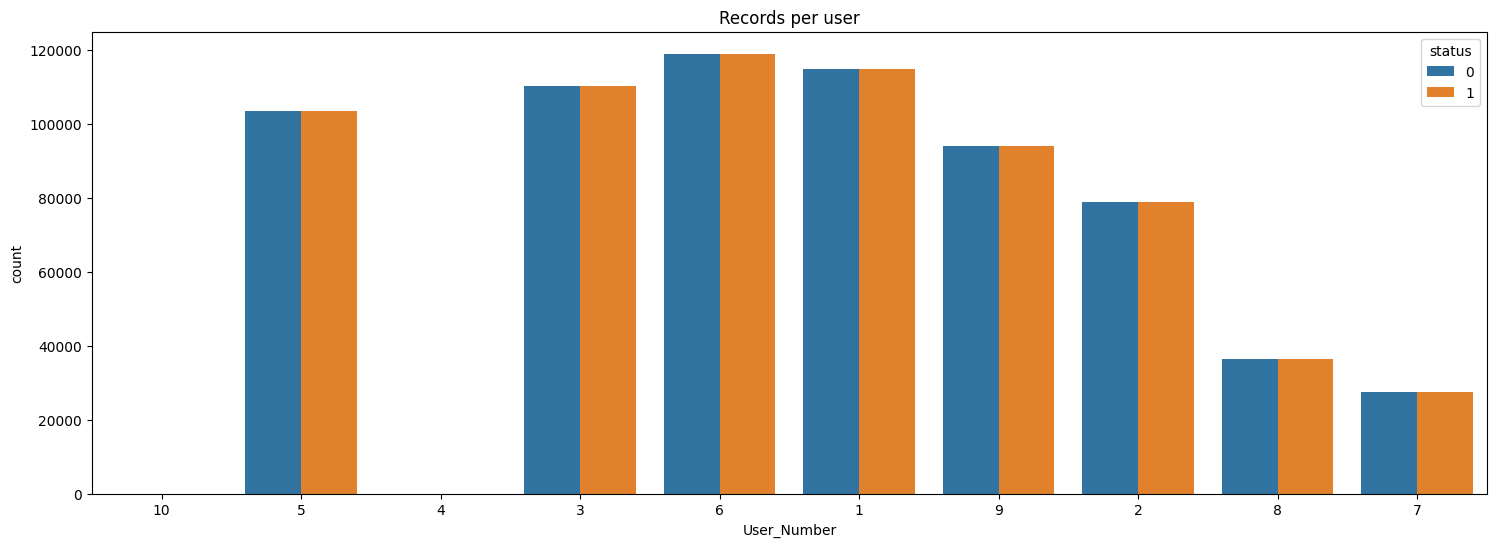

In [40]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "User_Number", hue="status", data = balanced_df,
              order = df.User_Number.value_counts().index)
plt.title("Records per user");

In [41]:
X = balanced_df[['TS', ' Ankel_1', 'Ankel_2', 'Ankel_3', 'Thigh_1', 'Thigh_2', 'Thigh_3',
       'Trunk_1', 'Trunk_2', 'Trunk_3']].values
y = balanced_df['status'].values.reshape(-1, 1)

In [42]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify= y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(876135, 10) (876135, 1)
(273793, 10) (273793, 1)


In [43]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(y_train)

y_train_hot = enc.transform(y_train) 
y_test_hot = enc.transform(y_test) 
y_val_hot = enc.transform(y_val)

In [44]:
n_features, n_outputs = X_train.shape[1], y_train_hot.shape[1]

In [45]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=(n_features,)))
model.add(keras.layers.Dense(128))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                704       
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                      

In [46]:
epochs, batch_size = 10, 128
history = model.fit(X_train, y_train_hot, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val_hot), shuffle=True)

Epoch 1/10
6845/6845 [==============================] - 19s 3ms/step - loss: 0.6376 - accuracy: 0.6252 - val_loss: 0.5766 - val_accuracy: 0.6742
Epoch 2/10
6845/6845 [==============================] - 18s 3ms/step - loss: 0.5788 - accuracy: 0.6778 - val_loss: 0.7042 - val_accuracy: 0.5496
Epoch 3/10
6845/6845 [==============================] - 19s 3ms/step - loss: 0.5734 - accuracy: 0.6833 - val_loss: 0.5669 - val_accuracy: 0.6953
Epoch 4/10
6845/6845 [==============================] - 18s 3ms/step - loss: 0.5694 - accuracy: 0.6875 - val_loss: 0.5743 - val_accuracy: 0.6693
Epoch 5/10
6845/6845 [==============================] - 19s 3ms/step - loss: 0.5612 - accuracy: 0.6962 - val_loss: 0.5531 - val_accuracy: 0.7000
Epoch 6/10
6845/6845 [==============================] - 18s 3ms/step - loss: 0.5558 - accuracy: 0.6997 - val_loss: 0.5486 - val_accuracy: 0.7076
Epoch 7/10
6845/6845 [==============================] - 19s 3ms/step - loss: 0.5535 - accuracy: 0.7002 - val_loss: 0.5561 - val_ac

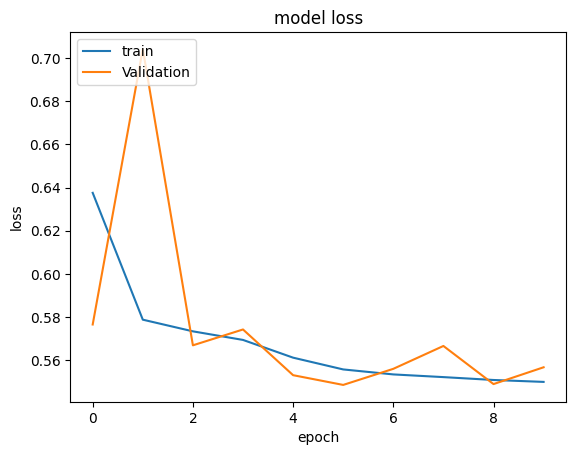

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

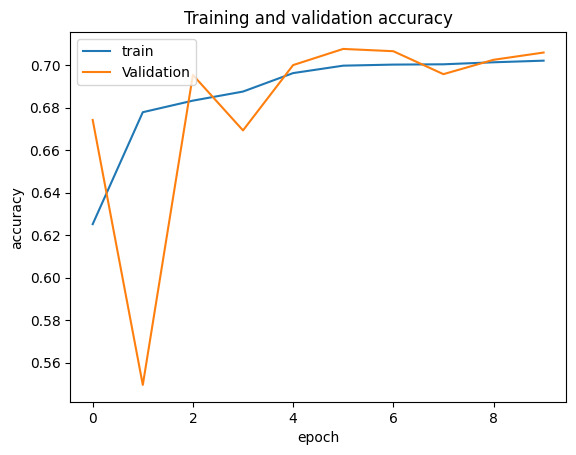

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

8557/8557 [==============================] - 7s 793us/step
f1_score =  0.6894090267973012
0.7061539192017326
              precision    recall  f1-score   support

           0       0.88      0.47      0.62    136897
           1       0.64      0.94      0.76    136896

    accuracy                           0.71    273793
   macro avg       0.76      0.71      0.69    273793
weighted avg       0.76      0.71      0.69    273793



<Axes: >

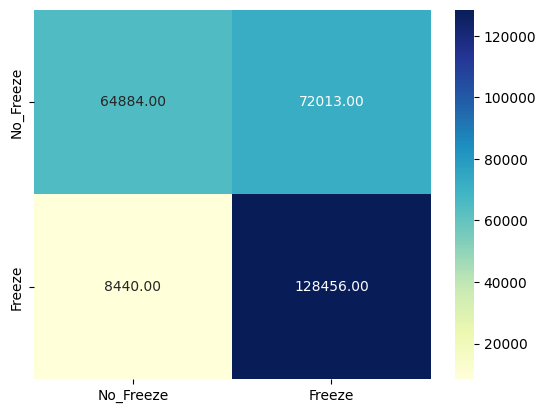

In [49]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['No_Freeze','Freeze']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')